<a href="https://colab.research.google.com/github/jb2467/SMRG_Video/blob/main/SMRG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Hello
# Using first study as training, second as validation, could still be 60/20/20
# standarized AOI
# Rules:
##

# Label, WE, P with the parts.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from google.colab.patches import cv2_imshow
# Factor decsion what they scored the part, transcrpits for correct partipants and make best AOI for that
# Make areas of interest for all the part



In [3]:

path = '/content/drive/MyDrive/SMRG/DFM 1/Participant15'

print(os.listdir(path))

subfolders = [f for f in os.listdir(path)]

videos = []

for subfolder in subfolders:
  files = os.listdir(path + '/' + subfolder)
  for file in files:
      videos.append(path + '/' + subfolder + '/' + file)
print(videos)

['P2', 'P3']
['/content/drive/MyDrive/SMRG/DFM 1/Participant15/P2/Fixation Graph.PNG', '/content/drive/MyDrive/SMRG/DFM 1/Participant15/P2/P 2 - Resp P 15 -.mp4', '/content/drive/MyDrive/SMRG/DFM 1/Participant15/P3/Fix Graph 100ms.PNG', '/content/drive/MyDrive/SMRG/DFM 1/Participant15/P3/P 3 - Resp P 15 (1).mp4']


/content/drive/MyDrive/SMRG/DFM 1/Participant15/P2/P 2 - Resp P 15 -.mp4
   start_time  gaze_x  gaze_y  radius  duration  end_time
0    0.366667    1338     386      12  0.433333  0.800000
1    1.000000    1272     614      13  0.800000  1.800000
2    2.066667     828     374      11  0.200000  2.266667
3    2.600000    1268     622       0  0.333333  2.933333
(4, 6)
Total gaze points detected: 84
    timestamp  gaze_x  gaze_y  radius
64   2.300000    1002     424      13
65   2.333333    1328     554      12
66   2.366667    1398     584      13
67   2.400000    1410     586      12
68   2.433333    1424     586      13
69   2.466667    1430     588      12
70   2.500000    1432     584      13
71   2.533333    1418     592      13
72   2.566667    1278     618      10
73   2.600000    1268     622      11
74   2.633333    1268     622      11
75   2.666667    1268     622      11
76   2.700000    1268     622      11
77   2.733333    1268     622      11
78   2.766667    1268     622

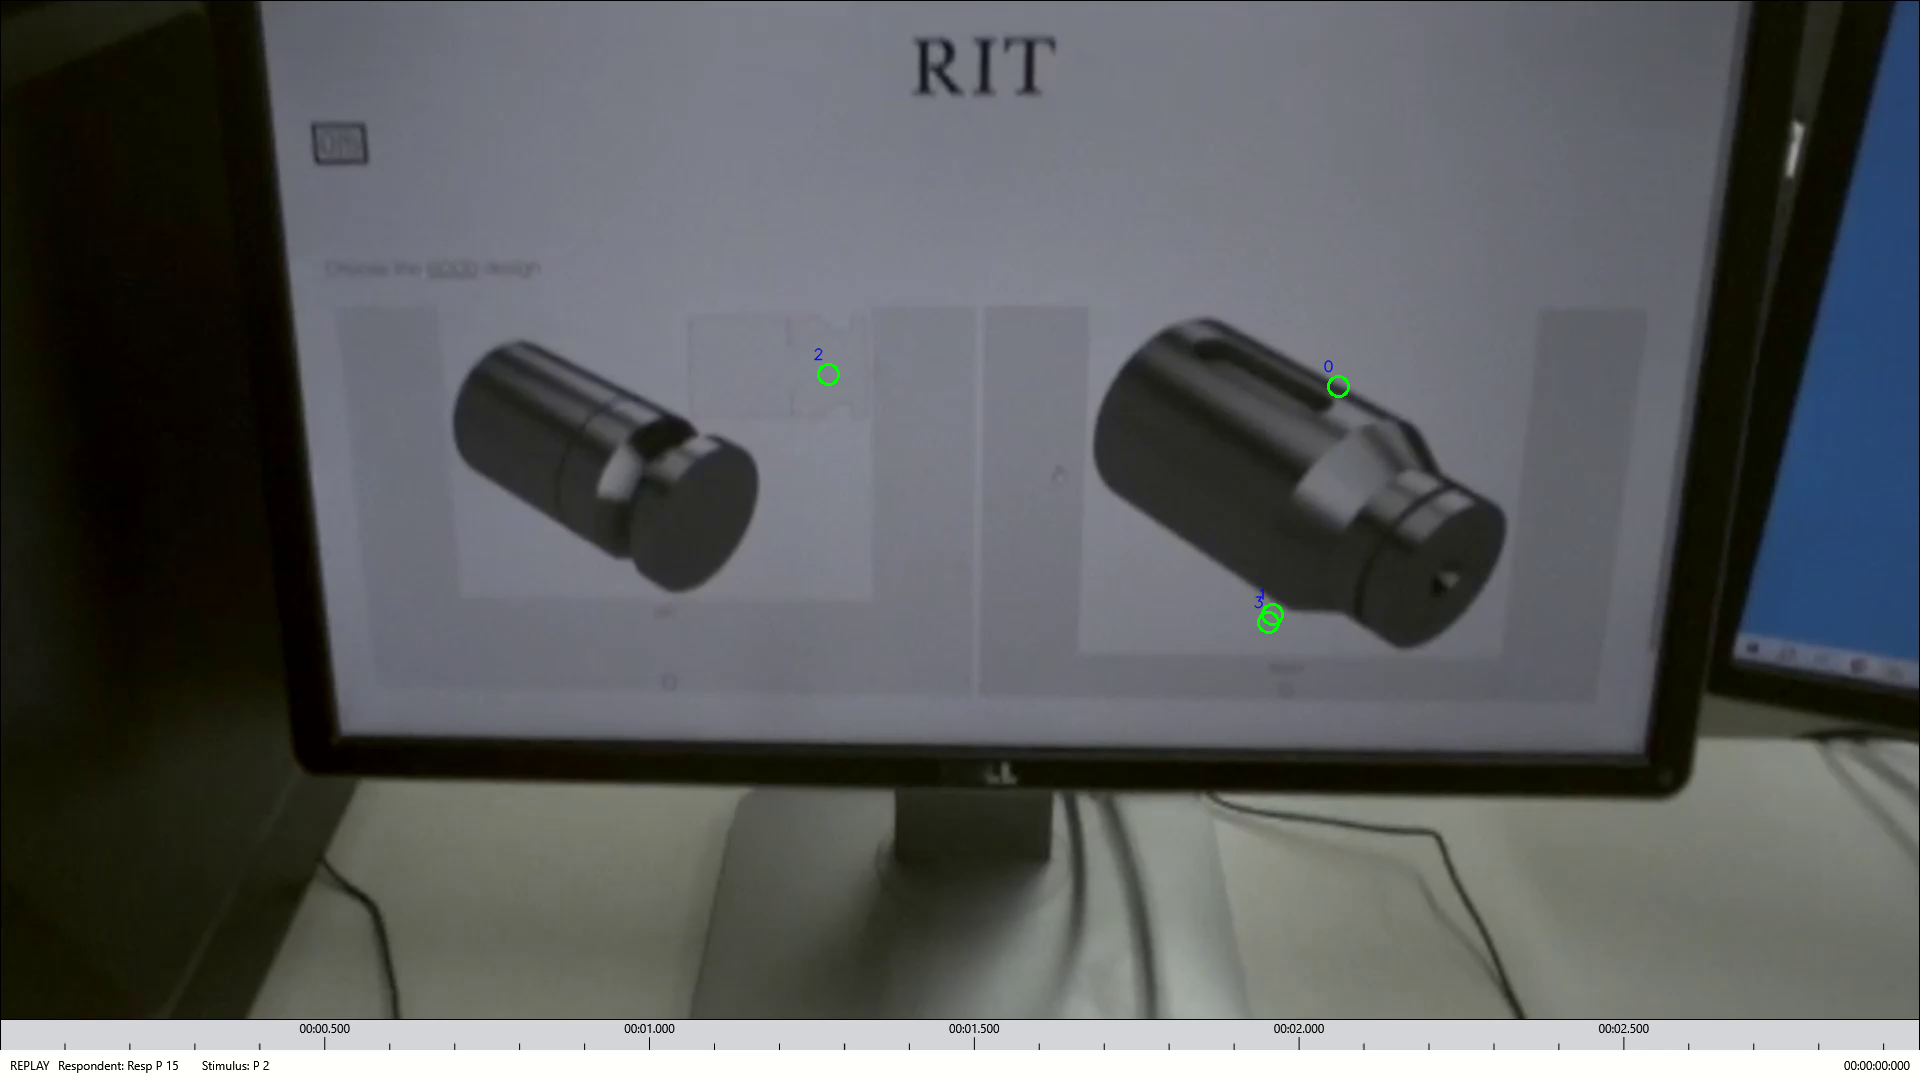

In [4]:
#20ms between fixations

def analyze_eye_tracking_video(video_file, movement_threshold=5, min_fixation_duration=0.20, grace_period_frames=10):
    cap = cv2.VideoCapture(video_file)
    gaze_data = []
    prev_x, prev_y = None, None  # Track previous gaze point
    start_time = None
    grace_period_counter = 0
    raw_gaze_data = []
    if not cap.isOpened():
        print(f"Error: Unable to open video file {video_file}")
        return None

    # Use actual FPS from video file
    fps = cap.get(cv2.CAP_PROP_FPS)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Use actual time per frame for more accurate timestamps
        current_time_raw = cap.get(cv2.CAP_PROP_POS_MSEC) / 1000  # Get timestamp in seconds

        gray = cv2.GaussianBlur(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), (5, 5), 0)
        circles = cv2.HoughCircles(
            gray, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=5, maxRadius=30
        )

        if circles is not None:
            circles = np.round(circles[0, :]).astype("int")
            for (x, y, r) in circles:
                grace_period_counter = 0  # Reset grace period
                raw_gaze_data.append([current_time_raw, x, y, r])
                if prev_x is not None and prev_y is not None:
                    distance_moved = np.sqrt((x - prev_x)**2 + (y - prev_y)**2)

                    if distance_moved > movement_threshold:
                        fixation_duration = current_time_raw - start_time
                        if fixation_duration >= min_fixation_duration - 1e-6:
                            end_time = start_time + fixation_duration
                            gaze_data.append([start_time, prev_x, prev_y, r, fixation_duration, end_time])

                        start_time = current_time_raw  # Reset start time for new fixation
                    prev_x, prev_y = x, y  # Update previous gaze point
                else:
                    start_time = current_time_raw  # Start new fixation
                    prev_x, prev_y = x, y

                break  # Use only the first circle detected
        else:
            grace_period_counter += 1
            if grace_period_counter > grace_period_frames and prev_x is not None:
                fixation_duration = current_time_raw - start_time
                if fixation_duration >= min_fixation_duration - 1e-6:
                    end_time = start_time + fixation_duration
                    gaze_data.append([start_time, prev_x, prev_y, 0, fixation_duration, end_time])

                prev_x, prev_y = None, None  # Reset when fixation ends

    if prev_x is not None:
        fixation_duration = current_time_raw - start_time
        if fixation_duration >= min_fixation_duration - 1e-6:
          end_time = start_time + fixation_duration
          gaze_data.append([start_time, prev_x, prev_y, 0, fixation_duration, end_time])

    cap.release()

    df = pd.DataFrame(gaze_data, columns=['start_time', 'gaze_x', 'gaze_y', 'radius', 'duration', 'end_time'])

    # Merge similar fixations if needed
    raw_df = pd.DataFrame(raw_gaze_data, columns=['timestamp', 'gaze_x', 'gaze_y', 'radius'])
    return df, raw_df


def display_fixations_on_video(video_file, gaze_df):
    cap = cv2.VideoCapture(video_file)

    if not cap.isOpened():
        print(f"Error: Unable to open video file {video_file}")
        return

    ret, frame = cap.read()
    if not ret:
        print("Error: Unable to read the first frame")
        return

    real_frame = frame.copy()

    for index, row in gaze_df.iterrows():
        x, y, r = int(row['gaze_x']), int(row['gaze_y']), 10
        cv2.circle(real_frame, (x, y), r, (0, 255, 0), 2)
        cv2.putText(real_frame, str(index), (x - r - 5, y - r - 5), cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, (255, 0, 0), 1, cv2.LINE_AA)
    cv2_imshow(real_frame)

    cap.release()
# Example usage
video_file = '/content/drive/MyDrive/SMRG/DFM 1/Participant15/P2/P 2 - Resp P 15 -.mp4'
print(video_file)
gaze_df, raw_df = analyze_eye_tracking_video(video_file)

if gaze_df is not None:
    print(gaze_df.tail(20))
    print(gaze_df.shape)
    print(f"Total gaze points detected: {raw_df.shape[0]}")
    print(raw_df.tail(20))
    display_fixations_on_video(video_file, gaze_df)
else:
    print("No valid gaze data to display.")


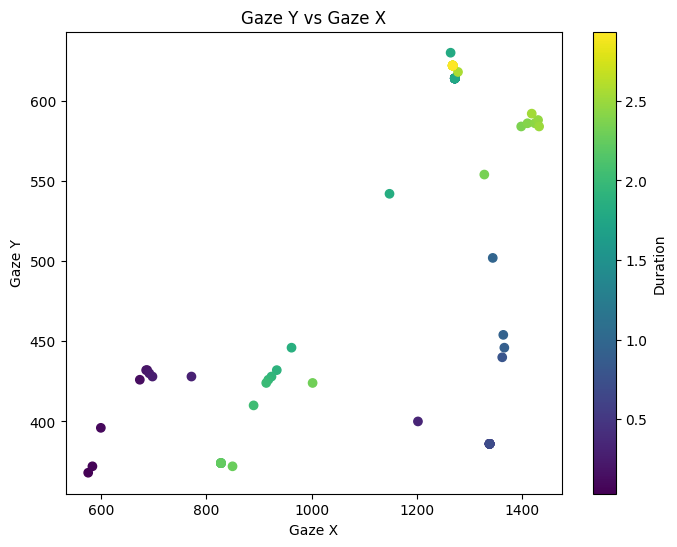

In [5]:

plt.figure(figsize=(8, 6))
plt.scatter(raw_df['gaze_x'], raw_df['gaze_y'], c=raw_df['timestamp'], cmap='viridis')
plt.xlabel('Gaze X')
plt.ylabel('Gaze Y')
plt.title('Gaze Y vs Gaze X')
_ = plt.colorbar(label='Duration')

In [6]:
gaze_df.shape

(4, 6)

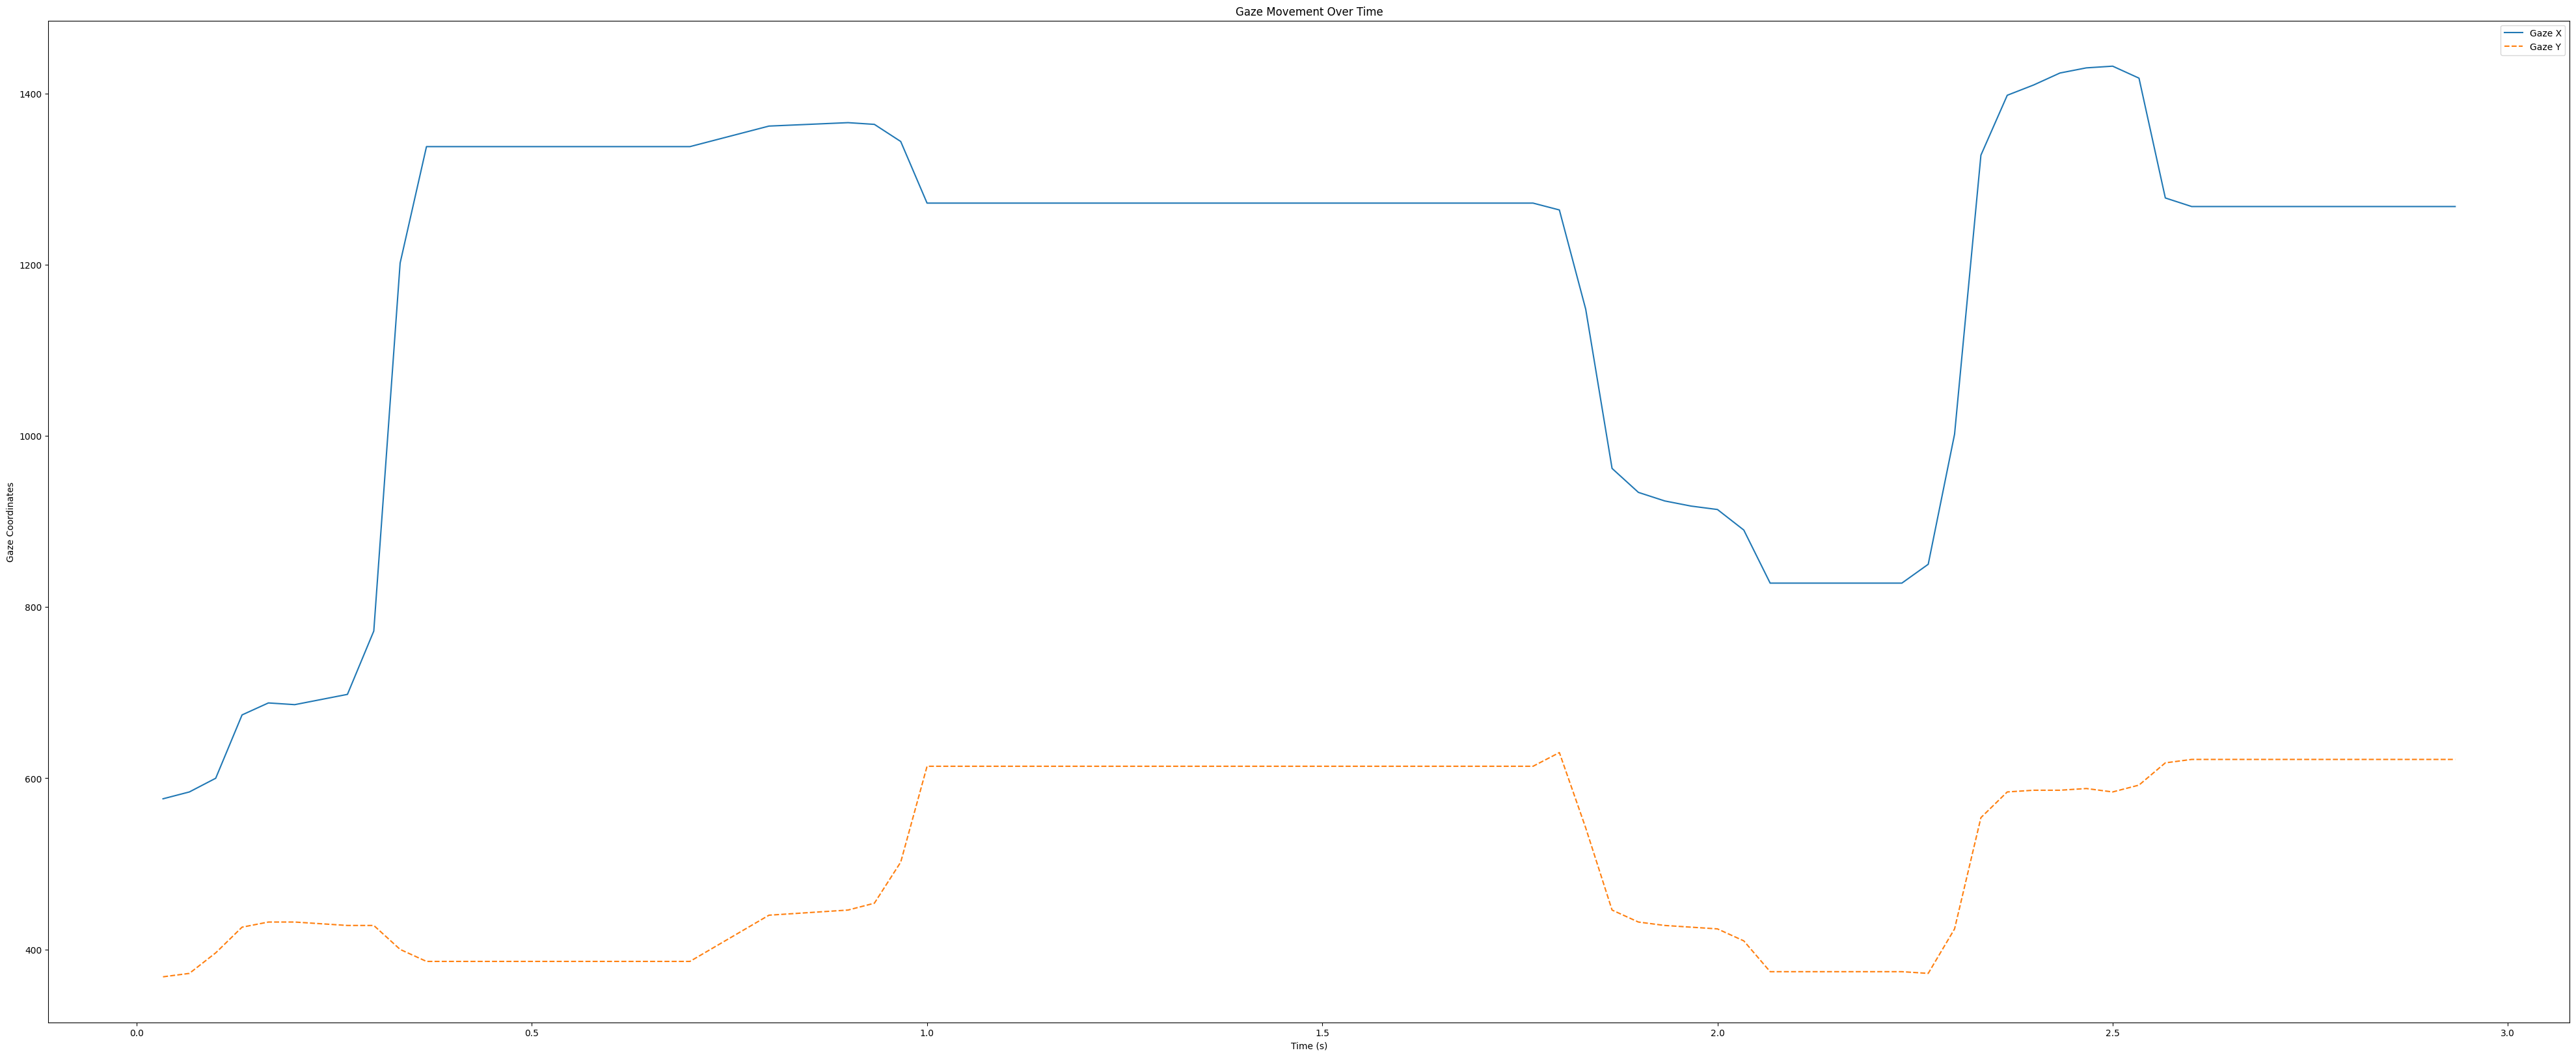

In [7]:
plt.figure(figsize=(50, 20))
plt.plot(raw_df['timestamp'], raw_df['gaze_x'], label='Gaze X')
plt.plot(raw_df['timestamp'], raw_df['gaze_y'], label='Gaze Y', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Gaze Coordinates')
plt.legend()
plt.title('Gaze Movement Over Time')

plt.show()


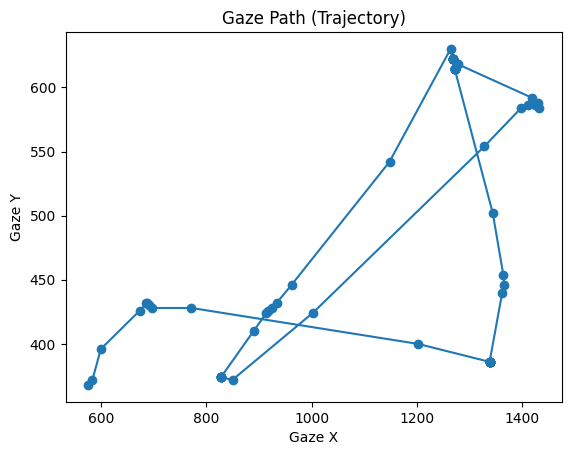

In [8]:
plt.plot(raw_df['gaze_x'], raw_df['gaze_y'], marker='o', linestyle='-')
plt.xlabel('Gaze X')
plt.ylabel('Gaze Y')
plt.title('Gaze Path (Trajectory)')
plt.show()


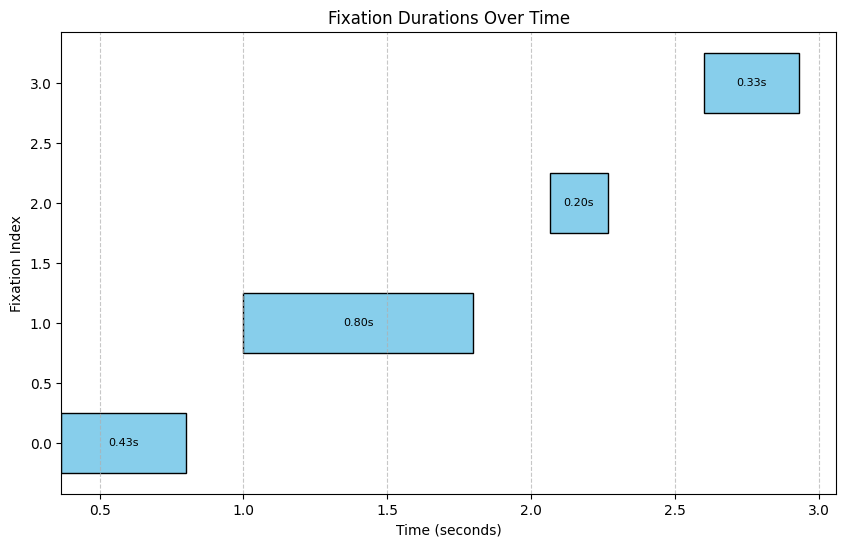

In [9]:

def plot_fixations(gaze_df):
    fig, ax = plt.subplots(figsize=(10, 6))

    for idx, row in gaze_df.iterrows():
        start = row['start_time']
        duration = row['duration']

        ax.barh(idx, duration, height=0.5, left=start, align='center', color='skyblue', edgecolor='black')
        ax.text(start + duration / 2, idx, f"{duration:.2f}s", ha='center', va='center', fontsize=8)

    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Fixation Index')
    ax.set_title('Fixation Durations Over Time')
    ax.grid(axis='x', linestyle='--', alpha=0.7)

    plt.show()

if gaze_df is not None and not gaze_df.empty:
    plot_fixations(gaze_df)
else:
    print("No valid fixation data to plot.")


sns

29.333333333333336


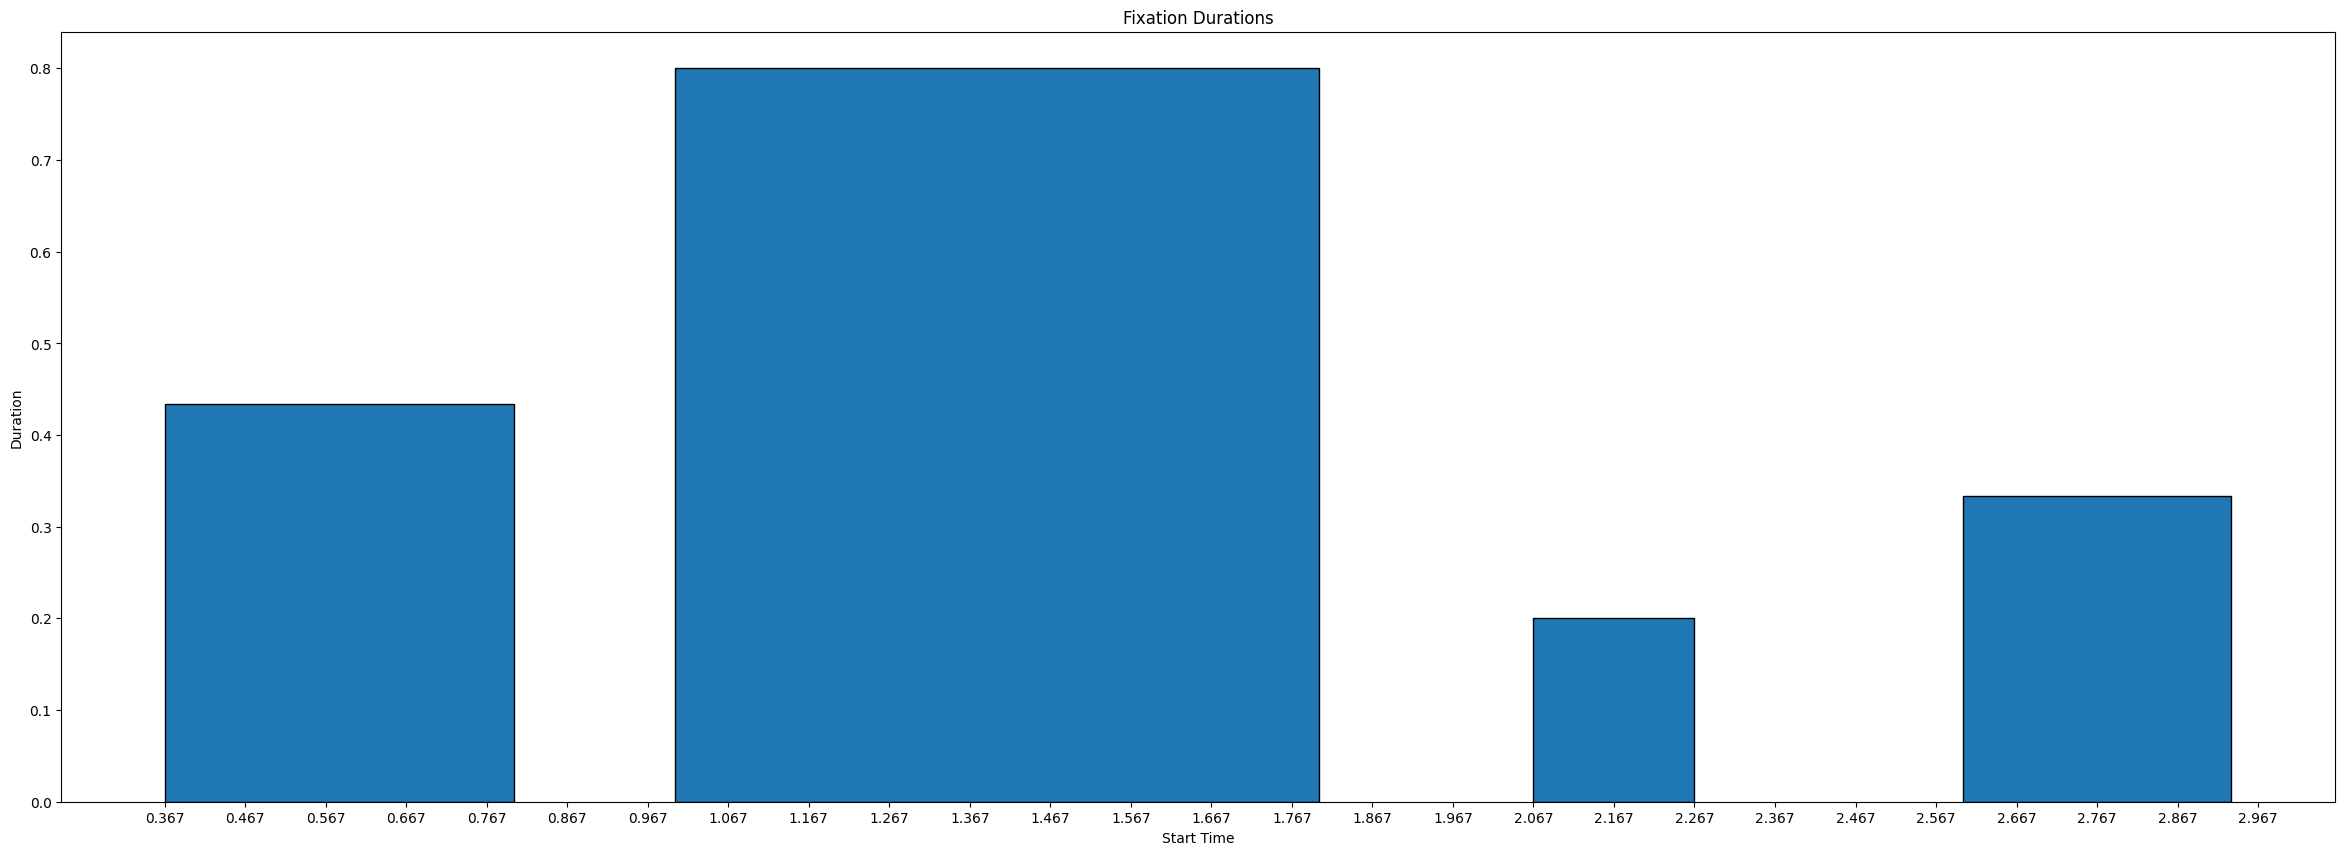

In [10]:
import matplotlib.pyplot as plt
import numpy as np

end_time = max(gaze_df['end_time'])
print(end_time/.1)
fig, ax = plt.subplots(figsize=(end_time/.1, 10))

start_times = gaze_df['start_time']
durations = gaze_df['duration']

ax.bar(start_times, durations, width=durations, align='edge', edgecolor='black')

ax.set_xlabel('Start Time')
ax.set_ylabel('Duration')
ax.set_title('Fixation Durations')

ax.set_xticks(np.arange(min(start_times), end_time +.1, 0.1))
plt.show()

<ipython-input-11-5fbe2f3d0f43>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(raw_df['radius'])


<Axes: xlabel='radius', ylabel='Density'>

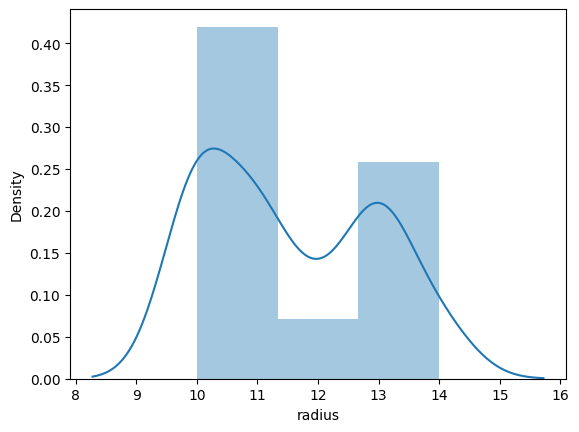

In [11]:
sns.distplot(raw_df['radius'])

<Axes: >

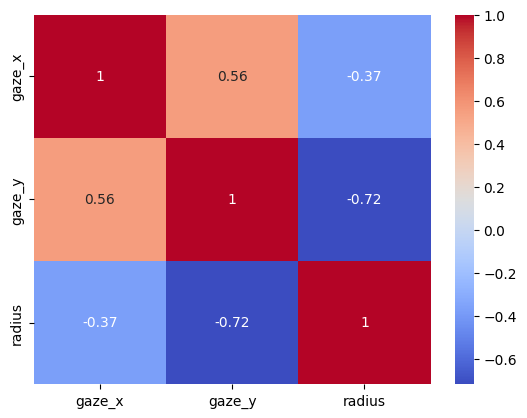

In [12]:
# prompt: make a correlation matrix with x, y

correlation_matrix = raw_df[['gaze_x', 'gaze_y', 'radius']].corr()
correlation_matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

<Axes: >

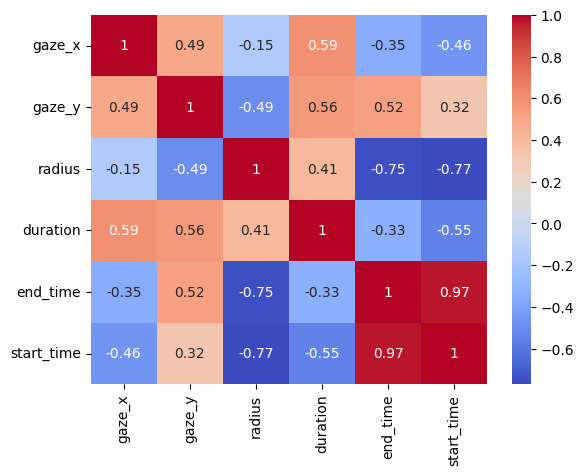

In [13]:
#generate a heatmap, to an image
matrix = gaze_df[['gaze_x', 'gaze_y', 'radius', 'duration', 'end_time', 'start_time']].corr()
matrix
sns.heatmap(matrix, annot=True, cmap='coolwarm')

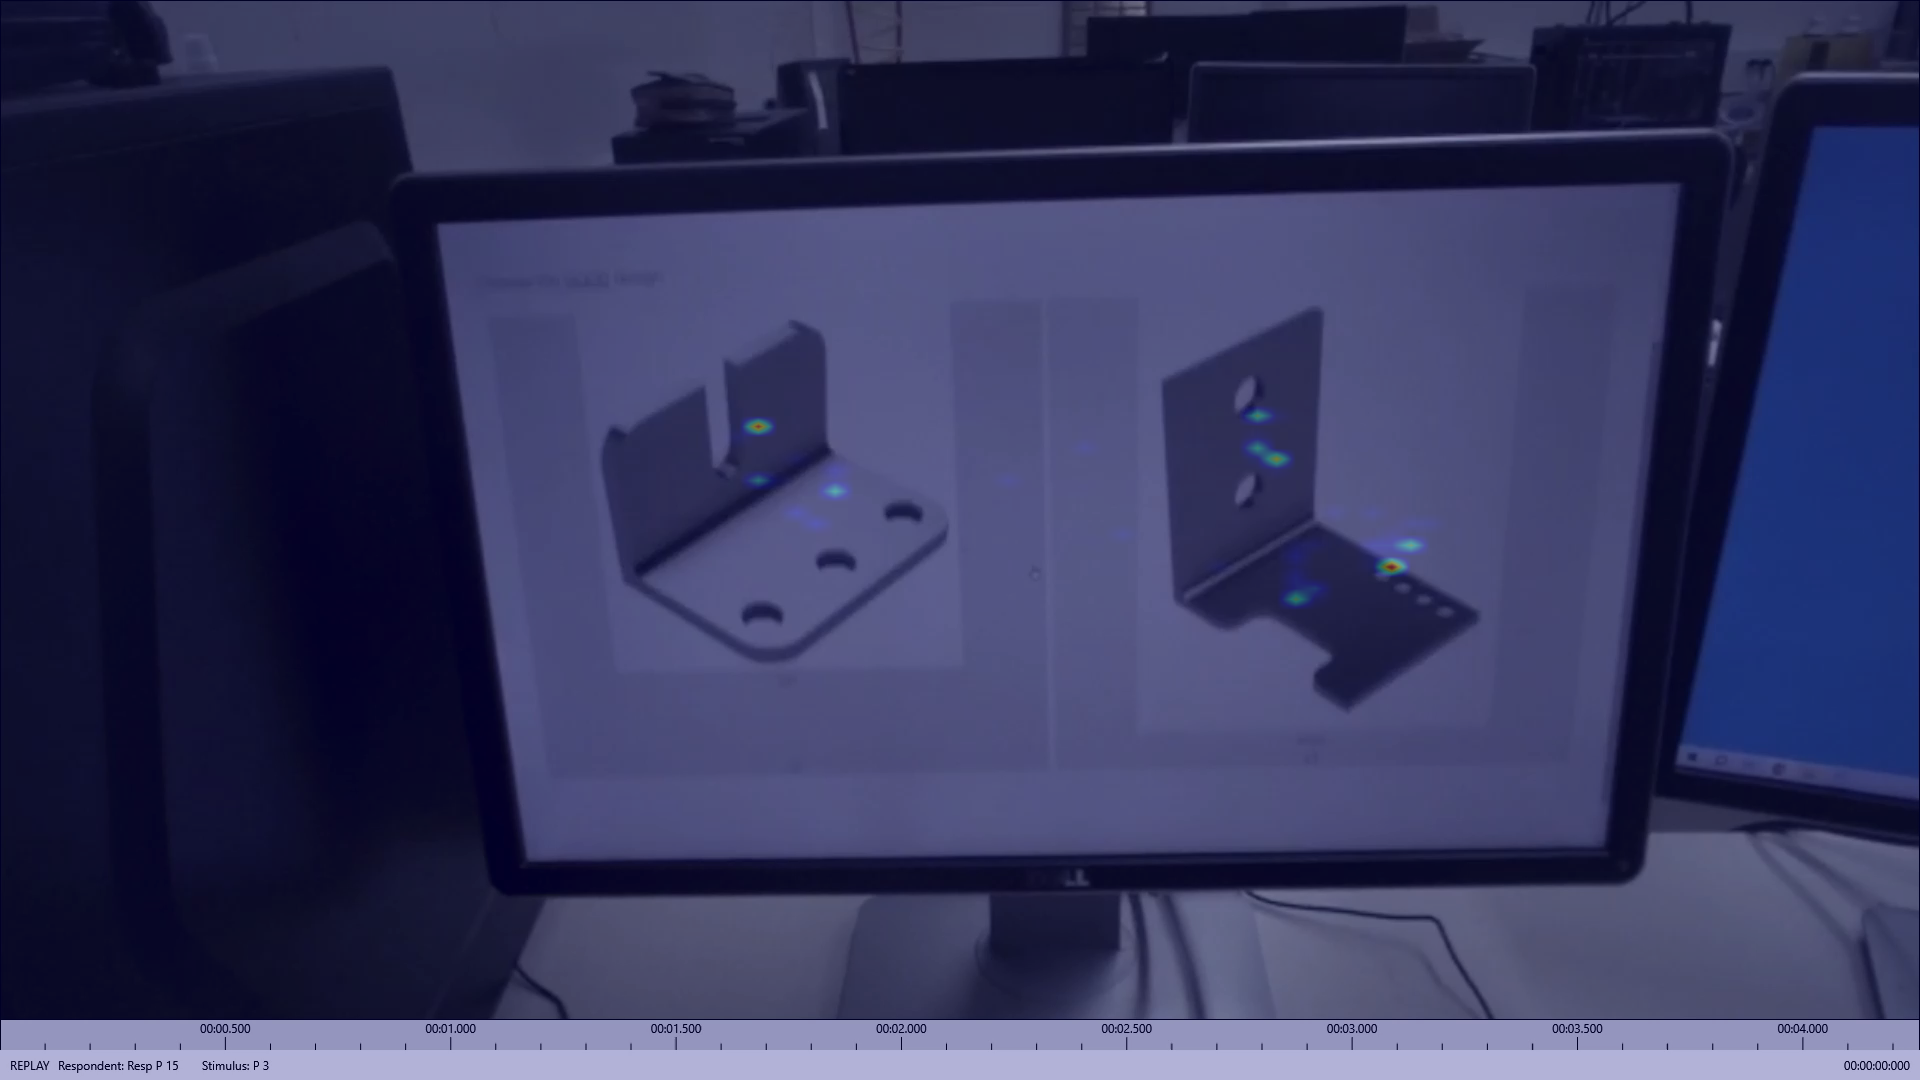

In [14]:
# prompt: With the raw data I want to make my own heat map and then plot it on the still frame

def create_heatmap_and_overlay(df, frame, heatmap_resolution=(100, 100)):
  heatmap_width, heatmap_height = heatmap_resolution

  heatmap = np.zeros((heatmap_height, heatmap_width), dtype=np.float32)
  for _, row in df.iterrows():
      x = int(row['gaze_x'] * heatmap_width / frame.shape[1])
      y = int(row['gaze_y'] * heatmap_height / frame.shape[0])
      if 0 <= x < heatmap_width and 0 <= y < heatmap_height:
          heatmap[y, x] += 1

  heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap) + 1e-8)

  heatmap = cv2.resize(heatmap, (frame.shape[1], frame.shape[0]))

  heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

  overlayed_frame = cv2.addWeighted(frame, 0.7, heatmap_color, 0.3, 0)

  return overlayed_frame


video_file = '/content/drive/MyDrive/SMRG/DFM 1/Participant15/P3/P 3 - Resp P 15 (1).mp4'
gaze_df, raw_df = analyze_eye_tracking_video(video_file)

cap = cv2.VideoCapture(video_file)

if not cap.isOpened():
    print(f"Error: Unable to open video file {video_file}")
else:
    ret, frame = cap.read()
    if ret:
        overlayed_frame = create_heatmap_and_overlay(raw_df, frame)
        cv2_imshow(overlayed_frame)
    else:
        print("Error: Unable to read a frame from the video.")

cap.release()

# I will give you 5 of the same stimuli with different participants. What we will do is tell it to generate statistics summarizing the fixations, proportion of faze/gaze, average time & number, etc. Once we get the statistics we identify the patterns and try to make connections.. 😃🔫

In [15]:
person_data = {
    'person_id': [1],
    'raw_data' : [raw_df],
    'gaze_data' : [gaze_df],
    'classifcation' : [1]
}

person_df = pd.DataFrame(person_data)
person_df.head()


,person_id,raw_data,gaze_data,classifcation
0,1,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius duratio...,1


In [16]:
person_df['raw_data'][0].head()

,timestamp,gaze_x,gaze_y,radius
0,0.033333,1294,582,12
1,0.066667,1294,576,12
2,0.100000,1294,566,12
3,0.133333,1296,558,13
4,0.166667,1298,554,13


In [17]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [18]:

def extract_features(gaze_df, raw_df):
  features = {}

  features['avg_fixation_duration'] = gaze_df['duration'].mean()
  features['std_fixation_duration'] = gaze_df['duration'].std()
  features['total_fixations'] = len(gaze_df)

  features['avg_gaze_x'] = raw_df['gaze_x'].mean()
  features['avg_gaze_y'] = raw_df['gaze_y'].mean()
  features['std_gaze_x'] = raw_df['gaze_x'].std()
  features['std_gaze_y'] = raw_df['gaze_y'].std()

  features['avg_radius'] = raw_df['radius'].mean()
  features['std_radius'] = raw_df['radius'].std()

  features['proportion_gaze'] = len(gaze_df) / len(raw_df)
  features['proportion_faze'] = 1 - features['proportion_gaze']

  features['fixation_rate'] = features['total_fixations'] / (raw_df['timestamp'].iloc[-1] - raw_df['timestamp'].iloc[0])
  features['avg_saccade_distance'] = np.mean(np.sqrt(np.diff(raw_df['gaze_x'])**2 + np.diff(raw_df['gaze_y'])**2))

  return features


In [19]:
features = extract_features(gaze_df, raw_df)
features_df = pd.DataFrame([features])
print(features_df.head())

   avg_fixation_duration  std_fixation_duration  total_fixations   avg_gaze_x  \
0               0.292593               0.090948                9  1167.206897   

   avg_gaze_y  std_gaze_x  std_gaze_y  avg_radius  std_radius  \
0   506.87931  248.648784    60.34699   12.681034    1.035031   

   proportion_gaze  proportion_faze  fixation_rate  avg_saccade_distance  
0         0.077586         0.922414       2.142857             25.655654  


In [20]:
path = '/content/drive/MyDrive/SMRG/Experiment #1'

print(os.listdir(path))

subfolders = [f for f in os.listdir(path)]

videos = []

for subfolder in subfolders:
  files = os.listdir(path + '/' + subfolder)
  for file in files:
      videos.append(path + '/' + subfolder + '/' + file)
print(videos)


['5+ Years', '0-4 Years', 'Test 5+ ', 'Test 0-4']
['/content/drive/MyDrive/SMRG/Experiment #1/5+ Years/P15  .mp4', '/content/drive/MyDrive/SMRG/Experiment #1/5+ Years/P 5 .mp4', '/content/drive/MyDrive/SMRG/Experiment #1/5+ Years/P 2 .mp4', '/content/drive/MyDrive/SMRG/Experiment #1/5+ Years/P 18.mp4', '/content/drive/MyDrive/SMRG/Experiment #1/0-4 Years/P 19 .mp4', '/content/drive/MyDrive/SMRG/Experiment #1/0-4 Years/P 16 .mp4', '/content/drive/MyDrive/SMRG/Experiment #1/0-4 Years/P 10 .mp4', '/content/drive/MyDrive/SMRG/Experiment #1/0-4 Years/P 3 .mp4', '/content/drive/MyDrive/SMRG/Experiment #1/0-4 Years/P 1.mp4']


In [21]:
import re
all_data = []
for video in videos:
  match = re.search(r"P\s*(\d+)", video)
  person_id = int(match.group(1))
  gaze_df, raw_df = analyze_eye_tracking_video(video)
  person_data = {
      'person_id': [person_id],
      'raw_data' : [raw_df],
      'gaze_data' : [gaze_df],
      'features' : [pd.DataFrame([extract_features(gaze_df, raw_df)])],
      'classifcation' : [1]
  }
  all_data.append(pd.DataFrame(person_data))

all_data = pd.concat(all_data, ignore_index=True)
all_data.head()




,person_id,raw_data,gaze_data,features,classifcation
0,15,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius duratio...,avg_fixation_duration std_fixation_duratio...,1
1,5,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius duratio...,avg_fixation_duration std_fixation_duratio...,1
2,2,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius durati...,avg_fixation_duration std_fixation_duratio...,1
3,18,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius durati...,avg_fixation_duration std_fixation_duratio...,1
4,19,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius durati...,avg_fixation_duration std_fixation_duratio...,1


In [22]:
all_data.head(10)

,person_id,raw_data,gaze_data,features,classifcation
0,15,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius duratio...,avg_fixation_duration std_fixation_duratio...,1
1,5,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius duratio...,avg_fixation_duration std_fixation_duratio...,1
2,2,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius durati...,avg_fixation_duration std_fixation_duratio...,1
3,18,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius durati...,avg_fixation_duration std_fixation_duratio...,1
4,19,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius durati...,avg_fixation_duration std_fixation_duratio...,1
5,16,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius duratio...,avg_fixation_duration std_fixation_duratio...,1
6,10,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius durati...,avg_fixation_duration std_fixation_duratio...,1
7,3,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius duratio...,avg_fixation_duration std_fixation_duratio...,1
8,1,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius durati...,avg_fixation_duration std_fixation_duratio...,1


In [23]:
person_ids_to_change = [2, 5, 15]
all_data.loc[all_data['person_id'].isin(person_ids_to_change), 'classifcation'] = 2

In [24]:
all_data.head(10)

,person_id,raw_data,gaze_data,features,classifcation
0,15,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius duratio...,avg_fixation_duration std_fixation_duratio...,2
1,5,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius duratio...,avg_fixation_duration std_fixation_duratio...,2
2,2,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius durati...,avg_fixation_duration std_fixation_duratio...,2
3,18,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius durati...,avg_fixation_duration std_fixation_duratio...,1
4,19,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius durati...,avg_fixation_duration std_fixation_duratio...,1
5,16,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius duratio...,avg_fixation_duration std_fixation_duratio...,1
6,10,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius durati...,avg_fixation_duration std_fixation_duratio...,1
7,3,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius duratio...,avg_fixation_duration std_fixation_duratio...,1
8,1,timestamp gaze_x gaze_y radius 0 0...,start_time gaze_x gaze_y radius durati...,avg_fixation_duration std_fixation_duratio...,1


In [25]:
import pandas as pd
from sklearn.model_selection import LeaveOneOut, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

features_expanded = pd.concat([f for f in all_data['features']], axis=0).reset_index(drop=True)

all_data_reset = all_data.drop(columns=['features']).reset_index(drop=True)
all_data_expanded = pd.concat([all_data_reset, features_expanded], axis=1)

X = all_data_expanded.drop(columns=['person_id', 'raw_data', 'gaze_data', 'classifcation'])
y = all_data_expanded['classifcation']

loo = LeaveOneOut()

models = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {'pipe__C': [0.1, 1, 10]}
    },
    'SVM': {
        'model': SVC(),
        'params': {'pipe__C': [0.1, 1, 10], 'pipe__kernel': ['linear', 'rbf']}
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {'pipe__n_estimators': [50, 100, 200], 'pipe__max_depth': [None, 10, 20]}
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(),
        'params': {'pipe__n_estimators': [50, 100], 'pipe__learning_rate': [0.01, 0.1, 1]}
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {'pipe__n_neighbors': [3, 5, 7]}
    }
}

# Loop through models
best_models = {}
loo = LeaveOneOut()  # Leave-One-Out Cross-Validation

for model_name, model_data in models.items():
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pipe', model_data['model'])
    ])

    scores = []
    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Use Leave-One-Out for grid search
        search = GridSearchCV(pipe, model_data['params'], cv=loo, scoring='accuracy', n_jobs=-1)
        search.fit(X_train, y_train)

        y_pred = search.best_estimator_.predict(X_test)
        scores.append((y_test.values[0], y_pred[0]))

    # Store best model and its performance
    best_models[model_name] = {
        'best_model': search.best_estimator_,
        'scores': scores
    }

# Print classification report for each model
for model_name, model_info in best_models.items():
    y_true, y_pred = zip(*model_info['scores'])
    print(f"Model: {model_name}")
    print(classification_report(y_true, y_pred))



Model: Logistic Regression
              precision    recall  f1-score   support

           1       0.57      0.67      0.62         6
           2       0.00      0.00      0.00         3

    accuracy                           0.44         9
   macro avg       0.29      0.33      0.31         9
weighted avg       0.38      0.44      0.41         9

Model: SVM
              precision    recall  f1-score   support

           1       0.62      0.83      0.71         6
           2       0.00      0.00      0.00         3

    accuracy                           0.56         9
   macro avg       0.31      0.42      0.36         9
weighted avg       0.42      0.56      0.48         9

Model: Random Forest
              precision    recall  f1-score   support

           1       0.57      0.67      0.62         6
           2       0.00      0.00      0.00         3

    accuracy                           0.44         9
   macro avg       0.29      0.33      0.31         9
weighted avg   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
